In [2]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GaussianNoise
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import glob
import os
from scipy.misc import imread, imresize
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray
from keras.utils import np_utils
import pywt
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from keras.initializers import glorot_uniform, Orthogonal

np.random.seed(seed=42)
glorot = glorot_uniform(seed=None)
orth = Orthogonal(gain=1.0, seed=None)

Using TensorFlow backend.


#### Load Data

In [3]:
master_folder = '../GrantData401Project4/PhotosDataset/'

imgs = []
labels = []
for photo in os.listdir(master_folder+'/Alex'):
    img = imread(master_folder+'/Alex/'+photo)
    imgs.append(resize(img,(200,200,4)))
    labels.append('Alex')
for photo in os.listdir(master_folder+'/Hunter'):
    img = imread(master_folder+'/Hunter/'+photo)
    imgs.append(resize(img,(200,200,4)))
    labels.append('Hunter')

c:\users\gjber\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
c:\users\gjber\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\gjber\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\gjber\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will

#### Massage Data

In [4]:
from sklearn.model_selection import StratifiedKFold

# Take out alpha component of image
imgs = [img[:,:,[0,1,2]] for img in imgs]
imgs = np.stack(imgs, axis=0)


num_classes = 2
num_channels = 3
batch_size=4
epochs=2
k = 10

strat_cv = StratifiedKFold(n_splits=k, shuffle=True)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

### Model with no transfer learning

In [12]:
def initialize_model():
    model = Sequential()

    # Note that we leave the image size as None to allow multiple image sizes
    model.add(Conv2D(48, (7, 7),strides=2, padding='same',
                     activation='relu',input_shape=(200, 200,num_channels),
                    name='input_layer'))
    model.add(MaxPooling2D((3,3)))
    model.add(GaussianNoise(.1))

    model.add(Conv2D(24, (3, 3),strides=1, padding='same',activation='relu'))
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(.3))

    # Classification layer
    model.add(Dense(2, activation='softmax'))

    # opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Cross Validate model

In [13]:
model_dict = {}
model_count = 0
for train_index, test_index in strat_cv.split(imgs, labels):
    model_count += 1
    
    curr_labels = np.array([[1,0] if label is 'Hunter' else [0,1] for label in labels])
    
    x_train = imgs[train_index,:,:]
    x_test = imgs[test_index,:,:]
    
    y_train = curr_labels[train_index,:]
    y_test = curr_labels[test_index,:]
    
    datagen.fit(x_train)

    model = initialize_model()
    
    callbacks = []
    callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                       patience=15, verbose=1, mode='auto',
                                       min_delta=0.0001, cooldown=0, min_lr=0))

    hist = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),verbose=1,
                        callbacks=callbacks)
    # Store models
    model_dict[model_count] = model
    
    

Epoch 1/2
83/83 [==============================] - 17s 206ms/step - loss: 0.0663 - acc: 0.9789 - val_loss: 2.5679e-06 - val_acc: 1.0000
Epoch 2/2
83/83 [==============================] - 15s 177ms/step - loss: 3.6733e-07 - acc: 1.0000 - val_loss: 2.3858e-06 - val_acc: 1.0000
Epoch 1/2
83/83 [==============================] - 17s 207ms/step - loss: 0.0774 - acc: 0.9789 - val_loss: 1.2404e-07 - val_acc: 1.0000
Epoch 2/2
83/83 [==============================] - 15s 179ms/step - loss: 1.8330e-07 - acc: 1.0000 - val_loss: 1.2243e-07 - val_acc: 1.0000
Epoch 1/2
83/83 [==============================] - 18s 216ms/step - loss: 0.2216 - acc: 0.9367 - val_loss: 9.0061e-06 - val_acc: 1.0000
Epoch 2/2
83/83 [==============================] - 16s 194ms/step - loss: 1.2316e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 1/2
83/83 [==============================] - 19s 224ms/step - loss: 0.1323 - acc: 0.9699 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/2
83/83 [===================

KeyboardInterrupt: 

### Utilize transfer learning

In [5]:
filepath = "caltech_101_raw_3_channel_bigger_conv.h5"
model = load_model(filepath)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 100, 100, 256)     62464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 33, 33, 256)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 33, 33, 128)       1605760   
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 32)          18464     
__________

In [6]:
for i in range(4):
    model.pop()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 100, 100, 256)     62464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 33, 33, 256)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 33, 33, 128)       1605760   
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 32)          18464     
__________

C:\Users\gjber\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [10]:
len(imgs)

369

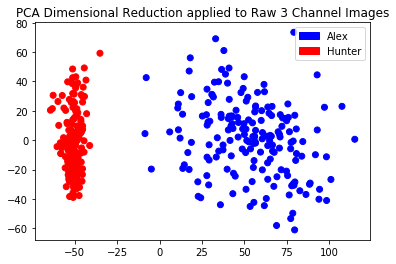

In [9]:
# trans_imgs = model.predict(imgs)

pca_imgs = imgs.reshape(len(imgs),-1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_imgs = pca.fit_transform(pca_imgs)

import matplotlib.patches as mpatches
alex = mpatches.Patch(color='blue', label='Alex')
hunter = mpatches.Patch(color='red', label='Hunter')

a = plt.scatter(pca_imgs[:,0],pca_imgs[:,1],
            c=['red' if label=='Hunter' else 'blue' for label in labels])

plt.legend(handles=[alex,hunter])
plt.title('PCA Dimensional Reduction applied to Raw 3 Channel Images')
plt.savefig('raw_dimension_reduction')

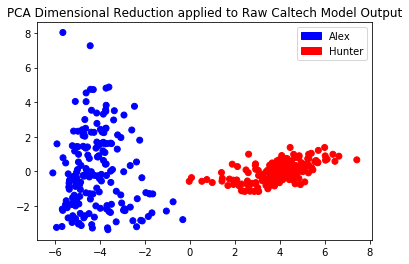

In [8]:
trans_imgs = model.predict(imgs)

trans_imgs = trans_imgs.reshape(369,-1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_trans_imgs = pca.fit_transform(trans_imgs)

import matplotlib.patches as mpatches
alex = mpatches.Patch(color='blue', label='Alex')
hunter = mpatches.Patch(color='red', label='Hunter')

a = plt.scatter(pca_trans_imgs[:,0],pca_trans_imgs[:,1],
            c=['red' if label=='Hunter' else 'blue' for label in labels])

plt.legend(handles=[alex,hunter])
plt.title('PCA Dimensional Reduction applied to Raw Caltech Model Output')
plt.savefig('Caltech_dimension_reduction')

In [8]:
def initialize_transfer_model():
    filepath = "caltech_101_raw_3_channel_bigger_conv.h5"
    trans_model = load_model(filepath)
    
    for i in range(4):
        trans_model.pop()
        
    # Allow no weight adjustments for the pretrained layers
    for layer in trans_model.layers:
        layer.trainable = False
        
    trans_model.add(Flatten())
#     trans_model.add(Dense(128,activation='relu', kernel_initializer=glorot))
#     transfer_model.add(Dropout(.3))
    # Classification Layer
    trans_model.add(Dense(num_classes, activation='softmax'))
    
    return trans_model

In [9]:
#data augmentation
datagen_transfer = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [10]:
trans_model_dict = {}
trans_model_hist_dict = {}
model_count = 0
for train_index, test_index in strat_cv.split(imgs, labels):
    model_count += 1
    
    curr_labels = np.array([[1,0] if label is 'Hunter' else [0,1] for label in labels])

    x_train = imgs[train_index,:,:]
    x_test = imgs[test_index,:,:]
    
    y_train = curr_labels[train_index,:]
    y_test = curr_labels[test_index,:]

    datagen_transfer.fit(x_train)

    transfer_model = initialize_transfer_model()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    transfer_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    
    callbacks = []
#     callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.5,
#                                        patience=2, verbose=1, mode='auto',
#                                        min_delta=0.03, cooldown=0, min_lr=0))
#     es = EarlyStopping(monitor='val_acc', mode='min', min_delta=.001, patience=3)
#     callbacks.append(es)

    test_datagen = ImageDataGenerator()
    test_datagen.fit(x_test)

    batch = 2
    hist = transfer_model.fit_generator(datagen_transfer.flow(x_train, y_train,
                                     batch_size=batch),
                        steps_per_epoch=x_train.shape[0] // batch,
                        epochs=2,
                            validation_data=test_datagen.flow(x_test, y_test),verbose=1,
                        callbacks=callbacks)
    # Store models
    trans_model_dict[model_count] = transfer_model
    trans_model_hist_dict[model_count] = hist

Epoch 1/2
166/166 [==============================] - 39s 235ms/step - loss: 0.0380 - acc: 0.9849 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 2/2
166/166 [==============================] - 47s 281ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1/2
166/166 [==============================] - 42s 253ms/step - loss: 0.0315 - acc: 0.9880 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/2
166/166 [==============================] - 48s 289ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 1/2
166/166 [==============================] - 47s 283ms/step - loss: 0.0328 - acc: 0.9880 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 2/2
166/166 [==============================] - 42s 255ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 1/2
166/166 [==============================] - 54s 328ms/step - loss: 0.0383 - acc: 0.9880 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2/2
166/166 [==============================] - 45s 273ms

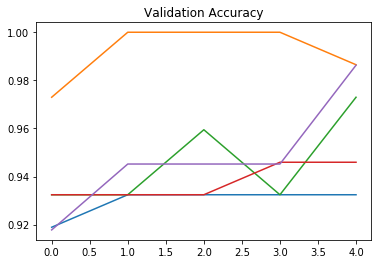

In [20]:
for hist in trans_model_hist_dict.values():
    plt.plot(hist.history['val_acc'])
    plt.title('Validation Accuracy')

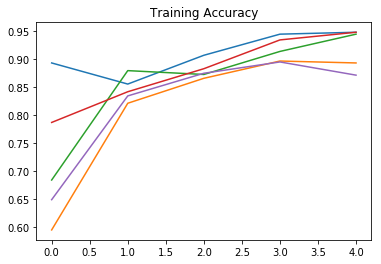

In [21]:
for hist in trans_model_hist_dict.values():
    plt.plot(hist.history['acc'])
    plt.title("Training Accuracy")

Evaluate

In [42]:
trans_pred = []
reg_pred= []
for img in x_test:
    trans_pred.append(trans_model.predict(np.expand_dims(img, axis=0)))
    reg_pred.append(model.predict(np.expand_dims(img, axis=0)))

reg_pred = ["Hunter" if x[0][0] > x[0][1] else "Alex" for x in reg_pred]
trans_pred = ["Hunter" if x[0][0] > x[0][1] else "Alex" for x in trans_pred]

y_test = ["Hunter" if x[0] > x[1] else "Alex" for x in y_test]

In [43]:
from sklearn.metrics import classification_report
print("Model with No transfer learning")
print(classification_report(y_test, reg_pred))
print("Model with transfer learning")
print(classification_report(y_test, trans_pred))

Model with No transfer learning
             precision    recall  f1-score   support

       Alex       1.00      1.00      1.00       259

avg / total       1.00      1.00      1.00       259

Model with transfer learning
             precision    recall  f1-score   support

       Alex       1.00      1.00      1.00       259

avg / total       1.00      1.00      1.00       259



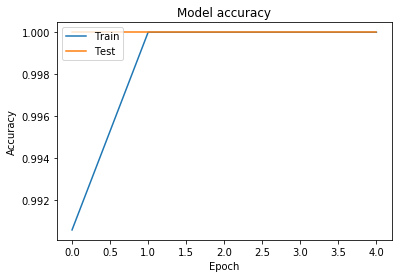

In [44]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

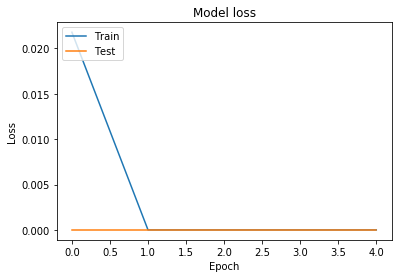

In [45]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()